In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import random
from skimage.filters import threshold_sauvola
from typing import List, Tuple
import matplotlib.pyplot as plt

def plot_tensors(tensors, titles):
    """Helper function to plot a list of tensors with titles."""
    count = len(tensors)
    fig, axes = plt.subplots(1, count, figsize=(count * 4.5, 4.5))
    if count == 1: axes = [axes]
    for i, (tensor, title) in enumerate(zip(tensors, titles)):
        img_np = tensor.cpu().detach().squeeze().numpy()
        axes[i].imshow(img_np, cmap='gray')
        axes[i].set_title(title, fontsize=12)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def calculate_iou(pred, target, threshold=0.5):
    """Calculates Intersection over Union (IoU) for a batch."""
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6) # Add epsilon to avoid division by zero
    return iou.mean()

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels: mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x): return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1); diffY = x2.size()[2] - x1.size()[2]; diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1); return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__(); self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__(); self.n_channels, self.n_classes, self.bilinear = n_channels, n_classes, bilinear
        self.inc = DoubleConv(n_channels, 64); self.down1, self.down2, self.down3 = Down(64, 128), Down(128, 256), Down(256, 512)
        factor = 2 if bilinear else 1; self.down4 = Down(512, 1024 // factor)
        self.up1, self.up2, self.up3 = Up(1024, 512 // factor, bilinear), Up(512, 256 // factor, bilinear), Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear); self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3); x5 = self.down4(x4)
        x = self.up1(x5, x4); x = self.up2(x, x3); x = self.up3(x, x2); x = self.up4(x, x1)
        return self.outc(x)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import random
from skimage.filters import threshold_sauvola
from typing import List, Tuple
import matplotlib.pyplot as plt

def plot_tensors(tensors, titles):
    """Helper function to plot a list of tensors with titles."""
    count = len(tensors)
    fig, axes = plt.subplots(1, count, figsize=(count * 4.5, 4.5))
    if count == 1: axes = [axes]
    for i, (tensor, title) in enumerate(zip(tensors, titles)):
        img_np = tensor.cpu().detach().squeeze().numpy()
        axes[i].imshow(img_np, cmap='gray')
        axes[i].set_title(title, fontsize=12)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def calculate_iou(pred, target, threshold=0.5):
    """Calculates Intersection over Union (IoU) for a batch."""
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6) # Add epsilon to avoid division by zero
    return iou.mean()

In [4]:
class DynamicInstanceDataset(Dataset):
    def __init__(self, image_paths: List[str], mask_paths: List[str], patch_size: Tuple[int, int], num_random_crops: int = 0, is_train: bool = False):
        self.image_paths, self.mask_paths = image_paths, mask_paths; self.patch_size = patch_size; self.is_train = is_train
        self.image_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.mask_transform = transforms.ToTensor(); self.patches = self._create_patches(num_random_crops)
    def _create_patches(self, num_random_crops):
        patches = []
        for idx, img_path in enumerate(self.image_paths):
            try:
                with Image.open(img_path) as img: w, h = img.size
            except FileNotFoundError: print(f"Warning: File not found {img_path}"); continue
            for i in range(0, h - self.patch_size[0] + 1, self.patch_size[0]):
                for j in range(0, w - self.patch_size[1] + 1, self.patch_size[1]): patches.append({'idx': idx, 't': i, 'l': j})
            if self.is_train:
                for _ in range(num_random_crops): patches.append({'idx': idx, 't': random.randint(0, h - self.patch_size[0]), 'l': random.randint(0, w - self.patch_size[1])})
        return patches
    def __len__(self): return len(self.patches)
    def __getitem__(self, i):
        p = self.patches[i]; img = Image.open(self.image_paths[p['idx']]).convert("RGB"); mask = Image.open(self.mask_paths[p['idx']]).convert("L")
        box = (p['l'], p['t'], p['l'] + self.patch_size[1], p['t'] + self.patch_size[0]);
        img_p, mask_p = self.image_transform(img.crop(box)), self.mask_transform(mask.crop(box))
        return img_p, (mask_p > 0.5).float()

def refine_with_sauvola(coarse_prediction: torch.Tensor, original_patch: torch.Tensor, threshold: float = 0.5) -> torch.Tensor:
    """
    Refines a coarse prediction using Sauvola binarization with a logical AND operation.
    The output is a guaranteed binary mask.
    """
    # 1. Binarize the coarse prediction from the U-Net (after sigmoid)
    binary_coarse_pred = (torch.sigmoid(coarse_prediction) > threshold).float()
    
    # 2. Get the binary mask from Sauvola applied to the original image patch
    original_patch_np = original_patch.cpu().squeeze(0).numpy()
    window_size = 25 
    thresh_sauvola = threshold_sauvola(original_patch_np, window_size=window_size)
    sauvola_mask_np = original_patch_np > thresh_sauvola
    sauvola_mask = torch.from_numpy(sauvola_mask_np).float().to(coarse_prediction.device)
    
    # 3. Perform a logical AND (element-wise multiplication of two binary masks)
    # This ensures the final output is also binary.
    refined_mask = binary_coarse_pred * sauvola_mask
    
    return refined_mask

In [5]:
# --- Hyperparameters ---
PATCH_SIZE = (256, 256)
NUM_RANDOM_CROPS = 50  # More augmentation is good with few training images
BATCH_SIZE = 8
EPOCHS = 1 # Let's train a bit longer
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")


# --- Define directory paths ---
TRAIN_IMG_DIR = "./data/U-DIADS-TL/Latin14396/img-Latin14396/training/"
TRAIN_MASK_DIR = "./data/U-DIADS-TL/Latin14396/text-line-gt-Latin14396/training/"

VAL_IMG_DIR = "./data/U-DIADS-TL/Latin14396/img-Latin14396/validation/"
VAL_MASK_DIR = "./data/U-DIADS-TL/Latin14396/text-line-gt-Latin14396/validation/"

TEST_IMG_DIR = "./data/U-DIADS-TL/Latin14396/img-Latin14396/test/"
TEST_MASK_DIR = "./data/U-DIADS-TL/Latin14396/text-line-gt-Latin14396/test/"

# --- Generate file lists (assuming consistent naming) ---
def get_file_paths(img_dir, mask_dir):
    images = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')])
    masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])
    return images, masks

TRAIN_IMAGE_PATHS, TRAIN_MASK_PATHS = get_file_paths(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
VAL_IMAGE_PATHS, VAL_MASK_PATHS = get_file_paths(VAL_IMG_DIR, VAL_MASK_DIR)
TEST_IMAGE_PATHS, TEST_MASK_PATHS = get_file_paths(TEST_IMG_DIR, TEST_MASK_DIR)

# Sanity check
print(f"Found {len(TRAIN_IMAGE_PATHS)} training images.")
print(f"Found {len(VAL_IMAGE_PATHS)} validation images.")
print(f"Found {len(TEST_IMAGE_PATHS)} test images.")
if not os.path.exists(TRAIN_IMAGE_PATHS[0]):
    print(f"\nWARNING: Training file not found at {TRAIN_IMAGE_PATHS[0]}. Please check your BASE_DIR.")

Using device: cpu
Found 3 training images.
Found 10 validation images.
Found 15 test images.


In [6]:
# --- Training Dataset (with random crops) ---
train_dataset = DynamicInstanceDataset(TRAIN_IMAGE_PATHS, TRAIN_MASK_PATHS, PATCH_SIZE, num_random_crops=NUM_RANDOM_CROPS, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
print(f"Training dataloader created with {len(train_dataset)} patches.")

# --- Validation Dataset (baseline patches only) ---
val_dataset = DynamicInstanceDataset(VAL_IMAGE_PATHS, VAL_MASK_PATHS, PATCH_SIZE, is_train=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
print(f"Validation dataloader created with {len(val_dataset)} patches.")

# --- Test Dataset (baseline patches only) ---
test_dataset = DynamicInstanceDataset(TEST_IMAGE_PATHS, TEST_MASK_PATHS, PATCH_SIZE, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
print(f"Test dataloader created with {len(test_dataset)} patches.")

Training dataloader created with 255 patches.
Validation dataloader created with 350 patches.
Test dataloader created with 525 patches.


In [7]:
model = UNet(n_channels=3, n_classes=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

best_val_iou = -1.0
print("\n--- Starting Training & Validation ---")

for epoch in range(EPOCHS):
    model.train(); running_train_loss, running_train_iou = 0.0, 0.0
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad(); outputs = model(images); loss = criterion(outputs, masks)
        loss.backward(); optimizer.step()
        running_train_loss += loss.item(); running_train_iou += calculate_iou(outputs, masks).item()
    
    avg_train_loss = running_train_loss / len(train_loader); avg_train_iou = running_train_iou / len(train_loader)

    model.eval(); running_val_loss, running_val_iou = 0.0, 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images); loss = criterion(outputs, masks)
            running_val_loss += loss.item(); running_val_iou += calculate_iou(outputs, masks).item()
            
    avg_val_loss = running_val_loss / len(val_loader); avg_val_iou = running_val_iou / len(val_loader)
    
    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {avg_train_loss:.4f} | Train IoU: {avg_train_iou:.4f} | Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f}")

    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  -> New best model saved with Val IoU: {best_val_iou:.4f}")

print("\n--- Training Finished ---")


--- Starting Training & Validation ---
Epoch 1/1 -> Train Loss: 0.4032 | Train IoU: 0.6433 | Val Loss: 0.3769 | Val IoU: 0.7386
  -> New best model saved with Val IoU: 0.7386

--- Training Finished ---


In [8]:
# Load the best model saved during training
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loss, test_iou = 0.0, 0.0
print("\n--- Running Final Evaluation on Test Set ---")
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)
from utils import hscp_eval
 
avg_test_loss = test_loss / len(test_loader)
avg_test_iou = test_iou / len(test_loader)

print(f"\n--- FINAL TEST RESULTS ---")
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Average Test IoU:  {avg_test_iou:.4f}")
print("--------------------------")


--- Running Final Evaluation on Test Set ---

--- FINAL TEST RESULTS ---
Average Test Loss: 0.0000
Average Test IoU:  0.0000
--------------------------



--- Visualizing Inference on a Test Patch ---


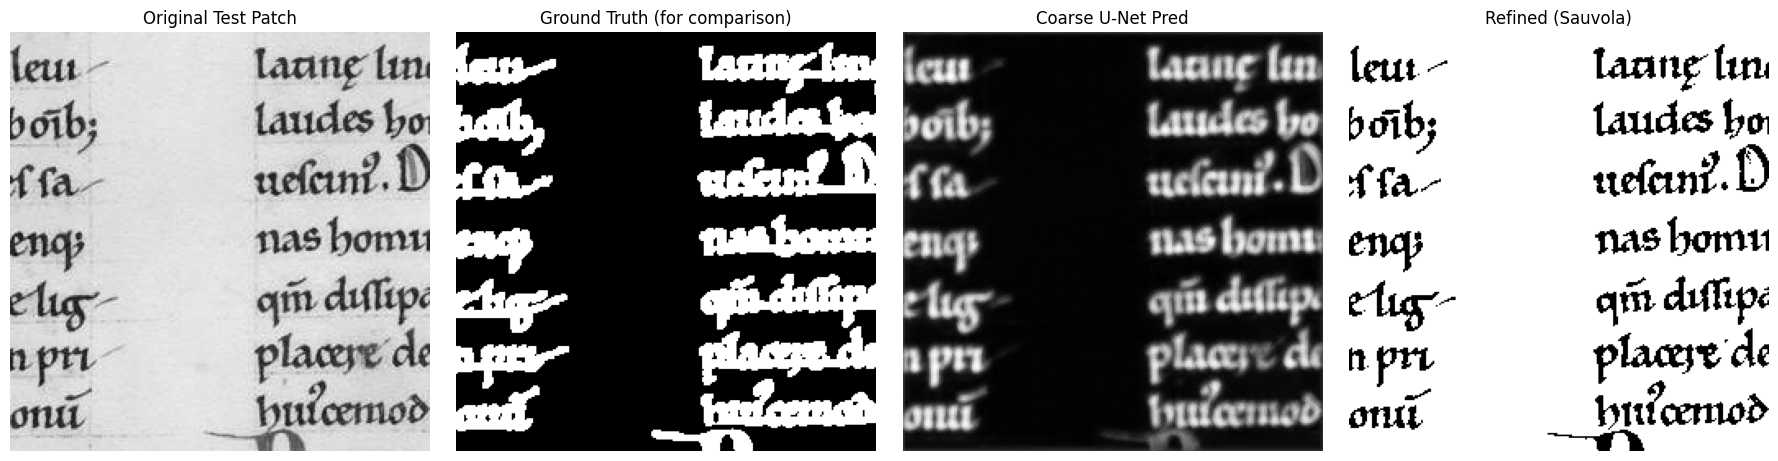

In [9]:
print("\n--- Visualizing Inference on a Test Patch ---")

# 1. Prepare Data from the test set
test_image_path = TEST_IMAGE_PATHS[0]
test_gt_mask_path = TEST_MASK_PATHS[0]

test_image_pil = Image.open(test_image_path).convert("RGB")
test_gt_mask_pil = Image.open(test_gt_mask_path).convert("L")

# Extract a patch
w, h = test_image_pil.size
top, left = h // 3, w // 3 # Pick a patch from an interesting area
box = (left, top, left + PATCH_SIZE[1], top + PATCH_SIZE[0])

original_patch_pil = test_image_pil.crop(box)
gt_mask_patch_pil = test_gt_mask_pil.crop(box)

# Convert to tensors
image_tensor = train_dataset.image_transform(original_patch_pil).unsqueeze(0).to(DEVICE)
gt_mask_tensor = transforms.ToTensor()(gt_mask_patch_pil)

# 2. Get Coarse Prediction from the model
with torch.no_grad():
    coarse_pred = torch.sigmoid(model(image_tensor))

# 3. Apply REALISTIC Refinement using Sauvola
# We need the original patch in grayscale for this
grayscale_patch_pil = original_patch_pil.convert("L")
grayscale_tensor = transforms.ToTensor()(grayscale_patch_pil)
refined_mask = refine_with_sauvola(coarse_pred, grayscale_tensor)

# 4. Visualize for comparison
plot_tensors(
    [transforms.ToTensor()(original_patch_pil).mean(0), gt_mask_tensor, coarse_pred, refined_mask],
    ["Original Test Patch", "Ground Truth (for comparison)", "Coarse U-Net Pred", "Refined (Sauvola)"]
)


--- Visualizing Full-Image Inference on a Random Test Image ---
Processing random test image: 223.jpg


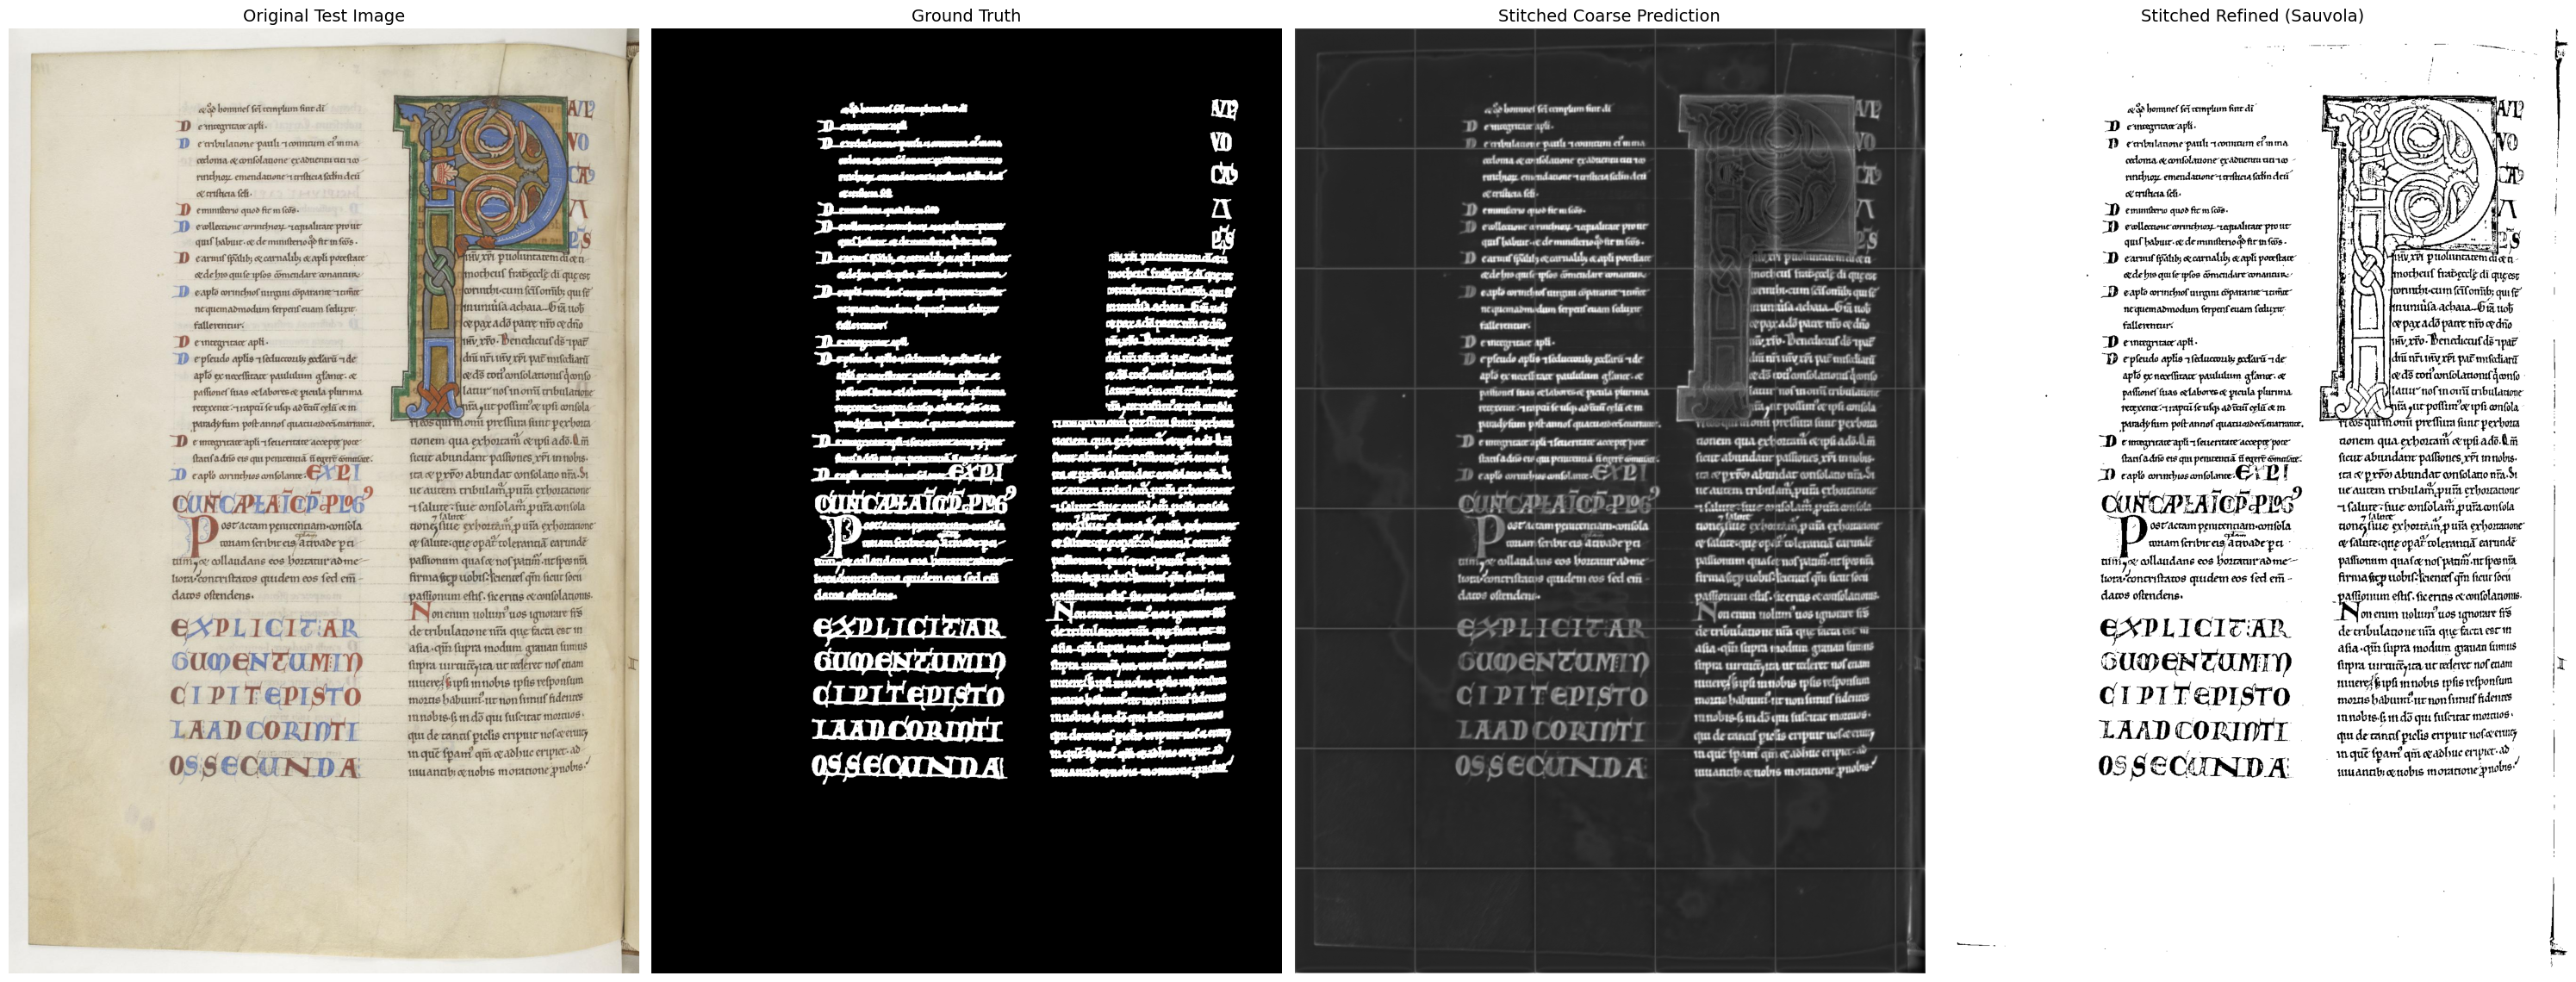

In [14]:
import math
import torch.nn.functional as F

print("\n--- Visualizing Full-Image Inference on a Random Test Image ---")

# --- 1. Select a Random Test Image ---
random_idx = random.randint(0, len(TEST_IMAGE_PATHS) - 1)
test_image_path = TEST_IMAGE_PATHS[random_idx]
test_gt_mask_path = TEST_MASK_PATHS[random_idx]

print(f"Processing random test image: {os.path.basename(test_image_path)}")

# Load the full-size images
full_image_pil = Image.open(test_image_path).convert("RGB")
full_gt_mask_pil = Image.open(test_gt_mask_path).convert("L")
W, H = full_image_pil.size

# --- 2. Prepare for Stitching ---
# Pad the image to be divisible by the patch size to avoid edge cases
pad_h = (PATCH_SIZE[0] - H % PATCH_SIZE[0]) % PATCH_SIZE[0]
pad_w = (PATCH_SIZE[1] - W % PATCH_SIZE[1]) % PATCH_SIZE[1]

# Use torchvision transforms for preprocessing and padding
preprocessor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((0, 0, pad_w, pad_h)), # (left, top, right, bottom)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
padded_image_tensor = preprocessor(full_image_pil).unsqueeze(0).to(DEVICE)
padded_H, padded_W = padded_image_tensor.shape[2], padded_image_tensor.shape[3]

# Create empty canvases to stitch the predictions onto
full_coarse_pred = torch.zeros((padded_H, padded_W), device=DEVICE)
full_refined_pred = torch.zeros((padded_H, padded_W), device=DEVICE)

# --- 3. Process Image Patch-by-Patch ---
model.eval()
with torch.no_grad():
    for y in range(0, padded_H, PATCH_SIZE[0]):
        for x in range(0, padded_W, PATCH_SIZE[1]):
            # Extract patch from the padded image tensor
            patch_tensor = padded_image_tensor[:, :, y:y+PATCH_SIZE[0], x:x+PATCH_SIZE[1]]
            
            # --- Coarse Prediction ---
            coarse_pred_patch = torch.sigmoid(model(patch_tensor))
            
            # --- Refined Prediction (Sauvola) ---
            # For refinement, we need the original (non-normalized) patch
            original_patch_pil = transforms.functional.crop(full_image_pil, y, x, PATCH_SIZE[0], PATCH_SIZE[1])
            grayscale_patch_pil = original_patch_pil.convert("L")
            grayscale_tensor = transforms.ToTensor()(grayscale_patch_pil)
            
            refined_pred_patch = refine_with_sauvola(coarse_pred_patch, grayscale_tensor)

            # Place the processed patch onto the full canvas
            full_coarse_pred[y:y+PATCH_SIZE[0], x:x+PATCH_SIZE[1]] = coarse_pred_patch.squeeze()
            full_refined_pred[y:y+PATCH_SIZE[0], x:x+PATCH_SIZE[1]] = refined_pred_patch.squeeze()

# --- 4. Crop Predictions Back to Original Size ---
full_coarse_pred = full_coarse_pred[:H, :W]
full_refined_pred = full_refined_pred[:H, :W]

# --- 5. Visualize the Full Results ---
fig, axes = plt.subplots(1, 4, figsize=(30, 15))

# Original Image
axes[0].imshow(full_image_pil)
axes[0].set_title('Original Test Image', fontsize=14)
axes[0].axis('off')

# Ground Truth Mask
axes[1].imshow(full_gt_mask_pil, cmap='gray')
axes[1].set_title('Ground Truth', fontsize=14)
axes[1].axis('off')

# Coarse Prediction
axes[2].imshow(full_coarse_pred.cpu().numpy(), cmap='gray')
axes[2].set_title('Stitched Coarse Prediction', fontsize=14)
axes[2].axis('off')

# Refined Prediction
axes[3].imshow(full_refined_pred.cpu().numpy(), cmap='gray')
axes[3].set_title('Stitched Refined (Sauvola)', fontsize=14)
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [17]:
import cv2
import numpy as np
from typing import List
from scipy.ndimage import label as find_connected_components

class BaselineExtractor:
    """
    An optional module to extract polynomial baselines from a binary text line segmentation mask.
    """
    def __init__(self, poly_degree: int = 2, min_points_for_fit: int = 20):
        self.poly_degree = poly_degree
        self.min_points = min_points_for_fit

    def extract(self, binary_mask: np.ndarray) -> list:
        if binary_mask.max() == 1:
            binary_mask = (binary_mask * 255).astype(np.uint8)

        labeled_mask, num_instances = find_connected_components(binary_mask)
        
        polynomials = []
        for i in range(1, num_instances + 1):
            instance_mask = (labeled_mask == i).astype(np.uint8)
            contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours: continue
            
            contour = max(contours, key=cv2.contourArea).squeeze()
            if len(contour) < self.min_points: continue

            bottom_points_map = {}
            for x, y in contour:
                if x not in bottom_points_map or y > bottom_points_map[x]:
                    bottom_points_map[x] = y
            
            if len(bottom_points_map) < self.min_points: continue

            x_coords = list(bottom_points_map.keys())
            y_coords = list(bottom_points_map.values())
            
            try:
                poly_coeffs = np.polyfit(x_coords, y_coords, self.poly_degree)
                polynomial = np.poly1d(poly_coeffs)
                polynomials.append((polynomial, min(x_coords), max(x_coords)))
            except (np.linalg.LinAlgError, TypeError):
                continue
                
        return polynomials

def draw_baselines_on_image(image: Image.Image, baselines: list) -> Image.Image:
    """Draws the extracted baseline curves onto an image."""
    img_cv = np.array(image.convert("RGB"))
    
    for poly, x_start, x_end in baselines:
        x_range = np.arange(x_start, x_end)
        y_range = poly(x_range).astype(int)
        
        points = np.vstack((x_range, y_range)).T.reshape((-1, 1, 2))
        cv2.polylines(img_cv, [points], isClosed=False, color=(255, 0, 0), thickness=2) # Draw in red
        
    return Image.fromarray(img_cv)

def clean_mask_with_morphology(binary_mask_np: np.ndarray, kernel_size: int = 5) -> np.ndarray:
    """
    Cleans a fragmented binary mask using morphological closing to connect nearby components.

    Args:
        binary_mask_np: The noisy/fragmented binary mask as a NumPy array.
        kernel_size: The size of the structuring element. Larger values connect more distant fragments.

    Returns:
        A cleaned, more solid binary mask.
    """
    # Create a square structuring element for the morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Ensure the input is a single-channel, uint8 NumPy array
    if binary_mask_np.max() == 1:
        binary_mask_np = (binary_mask_np * 255).astype(np.uint8)
    
    # Perform morphological closing (Dilation followed by Erosion)
    cleaned_mask = cv2.morphologyEx(binary_mask_np, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    return cleaned_mask


--- Visualizing Full-Image Inference on a Random Test Image ---
Processing random test image: 270.jpg
Extracted 3 baselines from the cleaned mask.


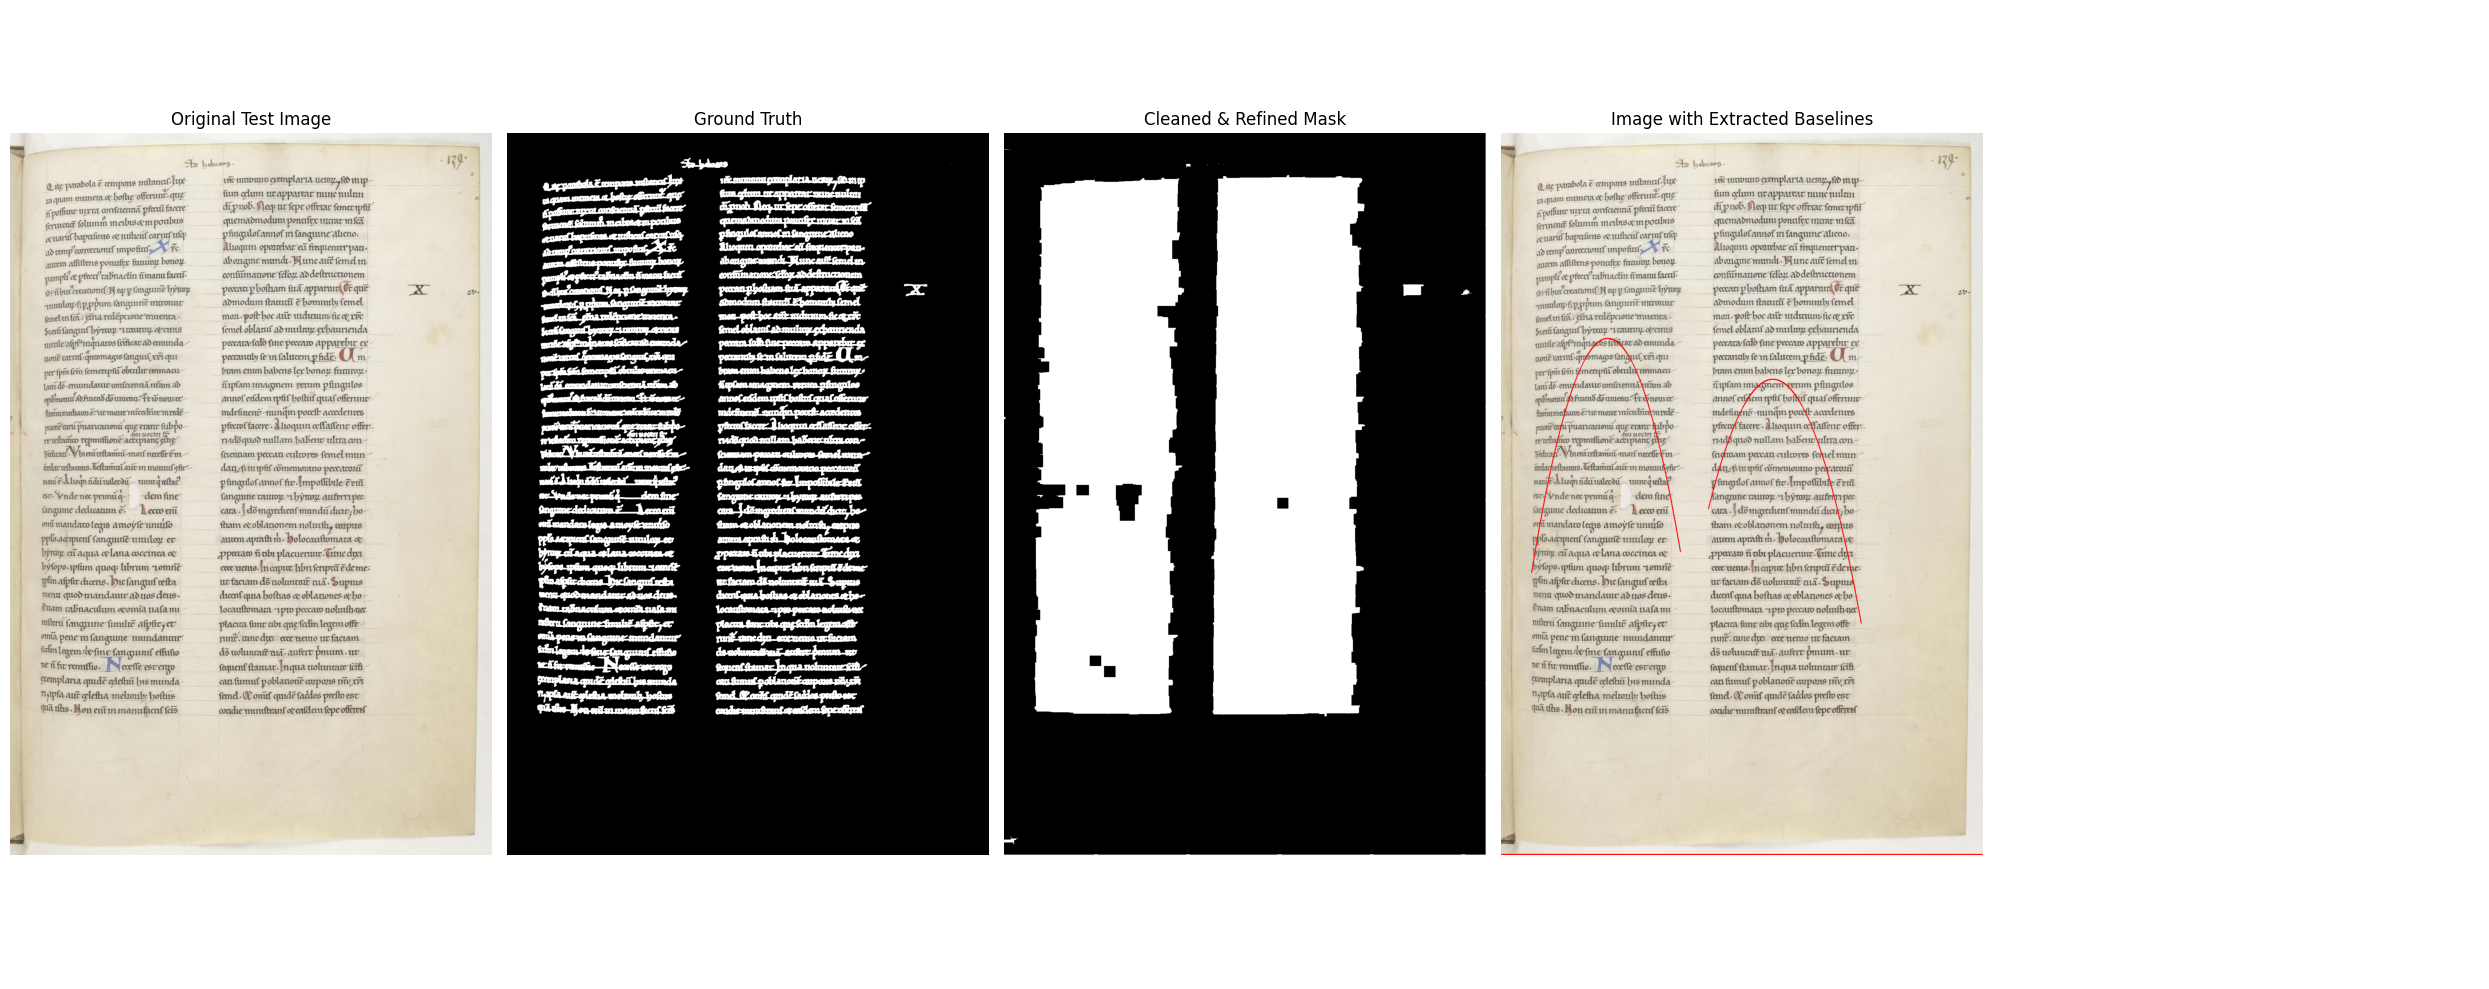

In [18]:
import math
import torch.nn.functional as F

print("\n--- Visualizing Full-Image Inference on a Random Test Image ---")

# --- 1. Select a Random Test Image ---
random_idx = random.randint(0, len(TEST_IMAGE_PATHS) - 1)
test_image_path = TEST_IMAGE_PATHS[random_idx]
test_gt_mask_path = TEST_MASK_PATHS[random_idx]

print(f"Processing random test image: {os.path.basename(test_image_path)}")

# Load the full-size images
full_image_pil = Image.open(test_image_path).convert("RGB")
full_gt_mask_pil = Image.open(test_gt_mask_path).convert("L")
W, H = full_image_pil.size

# --- 2. Prepare for Stitching ---
pad_h = (PATCH_SIZE[0] - H % PATCH_SIZE[0]) % PATCH_SIZE[0]
pad_w = (PATCH_SIZE[1] - W % PATCH_SIZE[1]) % PATCH_SIZE[1]

preprocessor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((0, 0, pad_w, pad_h)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
padded_image_tensor = preprocessor(full_image_pil).unsqueeze(0).to(DEVICE)
padded_H, padded_W = padded_image_tensor.shape[2], padded_image_tensor.shape[3]

full_coarse_pred = torch.zeros((padded_H, padded_W), device=DEVICE)
full_refined_pred = torch.zeros((padded_H, padded_W), device=DEVICE)

# --- 3. Process Image Patch-by-Patch ---
model.eval()
with torch.no_grad():
    for y in range(0, padded_H, PATCH_SIZE[0]):
        for x in range(0, padded_W, PATCH_SIZE[1]):
            patch_tensor = padded_image_tensor[:, :, y:y+PATCH_SIZE[0], x:x+PATCH_SIZE[1]]
            coarse_logits_patch = model(patch_tensor)
            coarse_prob_patch = torch.sigmoid(coarse_logits_patch)
            
            original_patch_pil = transforms.functional.crop(full_image_pil, y, x, PATCH_SIZE[0], PATCH_SIZE[1])
            grayscale_patch_pil = original_patch_pil.convert("L")
            grayscale_tensor = transforms.ToTensor()(grayscale_patch_pil)
            
            refined_pred_patch = refine_with_sauvola(coarse_logits_patch, grayscale_tensor)

            full_coarse_pred[y:y+PATCH_SIZE[0], x:x+PATCH_SIZE[1]] = coarse_prob_patch.squeeze()
            full_refined_pred[y:y+PATCH_SIZE[0], x:x+PATCH_SIZE[1]] = refined_pred_patch.squeeze()

# --- 4. Crop Predictions Back to Original Size ---
full_coarse_pred = full_coarse_pred[:H, :W]
full_refined_pred = full_refined_pred[:H, :W]

# --- 5. Clean the Mask and Extract Baselines ---
# Convert the final refined mask to a NumPy array for processing
final_mask_np = full_refined_pred.cpu().numpy()

# ==============================================================================
#                      >>> NEW MASK CLEANING STEP <<<
# ==============================================================================
# Use our new function to connect the fragmented text lines
# You might need to adjust the kernel_size for different document types
cleaned_mask_np = clean_mask_with_morphology(final_mask_np, kernel_size=15)
# ==============================================================================

# Instantiate the extractor and run it on the CLEANED mask
baseline_extractor = BaselineExtractor(poly_degree=2)
extracted_baselines = baseline_extractor.extract(cleaned_mask_np) # Use cleaned_mask_np
print(f"Extracted {len(extracted_baselines)} baselines from the cleaned mask.")

# Draw the curves on the original image for the final plot
image_with_baselines = draw_baselines_on_image(full_image_pil, extracted_baselines)


# --- 6. Visualize the Full Results (with the cleaned mask) ---
fig, axes = plt.subplots(1, 5, figsize=(25, 10))

axes[0].imshow(full_image_pil); axes[0].set_title('Original Test Image'); axes[0].axis('off')
axes[1].imshow(full_gt_mask_pil, cmap='gray'); axes[1].set_title('Ground Truth'); axes[1].axis('off')

# For clarity, let's show the CLEANED mask, not the noisy one
axes[2].imshow(cleaned_mask_np, cmap='gray'); axes[2].set_title('Cleaned & Refined Mask'); axes[2].axis('off')

# We can remove the coarse and original refined plots as they are less useful now
# Or keep them if you prefer. Let's show the baselines.
axes[3].imshow(image_with_baselines); axes[3].set_title('Image with Extracted Baselines'); axes[3].axis('off')

# Hide the last unused plot
axes[4].axis('off')

# Adjust layout and show
fig.tight_layout()
plt.show()

In [36]:
# # save predicted masks

# import cv2
# from numpy import full


# full_coarse_pred_np = (full_coarse_pred.cpu().numpy() * 255).astype(np.uint8)
# full_refined_pred_np = (full_refined_pred.cpu().numpy() * 255).astype(np.uint8)

# # binarize the coarse prediction with otsu

# _, full_coarse_pred_np = cv2.threshold(full_coarse_pred_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# cv2.imwrite('full_coarse_pred.png', full_coarse_pred_np)
# cv2.imwrite('full_refined_pred.png', full_refined_pred_np)    

In [37]:
# from utils.hscp_eval import hscp_pixel_eval

# gt_img = cv2.imread(test_gt_mask_path, cv2.IMREAD_GRAYSCALE)
# pred_img = full_coarse_pred_np

# dr, ra, fm = hscp_pixel_eval(gt_img, pred_img)

# print(f"HSCP -> DR: {dr:.2f}, RA: {ra:.2f}, FM: {fm:.2f}")

# from utils.diva_eval import diva_pixel_eval

# iou, piou = diva_pixel_eval(gt_img, pred_img)

# print(f"Diva -> Pixel IoU: {iou:.2f}, Line IoU: {piou:.2f}")


In [38]:
# # plot gt_img and pred_img
# plt.figure(figsize=(20, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(gt_img, cmap='gray')
# plt.title('Ground Truth')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(pred_img, cmap='gray')
# plt.title('Coarse Prediction')
# plt.axis('off')
# plt.tight_layout()
# plt.show()


In [39]:
# import math
# import torch.nn.functional as F

# print("\n--- Visualizing Full-Image Inference on a Random Test Image ---")

# # --- 1. Select a Random Test Image ---

# test_image_path = "./data/DIVA-HIsDB/all/img-CB55/img/public-test/e-codices_fmb-cb-0055_0098v_max.jpg"
# test_gt_mask_path = "./data/DIVA-HIsDB/all/pixel-level-gt-CB55/pixel-level-gt/public-test/e-codices_fmb-cb-0055_0098v_max.png"

# print(f"Processing random test image: {os.path.basename(test_image_path)}")

# # Load the full-size images
# full_image_pil = Image.open(test_image_path).convert("RGB")
# full_gt_mask_pil = Image.open(test_gt_mask_path).convert("L")
# W, H = full_image_pil.size

# # --- 2. Prepare for Stitching ---
# # Pad the image to be divisible by the patch size to avoid edge cases
# pad_h = (PATCH_SIZE[0] - H % PATCH_SIZE[0]) % PATCH_SIZE[0]
# pad_w = (PATCH_SIZE[1] - W % PATCH_SIZE[1]) % PATCH_SIZE[1]

# # Use torchvision transforms for preprocessing and padding
# preprocessor = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Pad((0, 0, pad_w, pad_h)), # (left, top, right, bottom)
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# padded_image_tensor = preprocessor(full_image_pil).unsqueeze(0).to(DEVICE)
# padded_H, padded_W = padded_image_tensor.shape[2], padded_image_tensor.shape[3]

# # Create empty canvases to stitch the predictions onto
# full_coarse_pred = torch.zeros((padded_H, padded_W), device=DEVICE)
# full_refined_pred = torch.zeros((padded_H, padded_W), device=DEVICE)

# # --- 3. Process Image Patch-by-Patch ---
# model.eval()
# with torch.no_grad():
#     for y in range(0, padded_H, PATCH_SIZE[0]):
#         for x in range(0, padded_W, PATCH_SIZE[1]):
#             # Extract patch from the padded image tensor
#             patch_tensor = padded_image_tensor[:, :, y:y+PATCH_SIZE[0], x:x+PATCH_SIZE[1]]
            
#             # --- Coarse Prediction ---
#             coarse_pred_patch = torch.sigmoid(model(patch_tensor))
            
#             # --- Refined Prediction (Sauvola) ---
#             # For refinement, we need the original (non-normalized) patch
#             original_patch_pil = transforms.functional.crop(full_image_pil, y, x, PATCH_SIZE[0], PATCH_SIZE[1])
#             grayscale_patch_pil = original_patch_pil.convert("L")
#             grayscale_tensor = transforms.ToTensor()(grayscale_patch_pil)
            
#             refined_pred_patch = refine_with_sauvola(coarse_pred_patch, grayscale_tensor)

#             # Place the processed patch onto the full canvas
#             full_coarse_pred[y:y+PATCH_SIZE[0], x:x+PATCH_SIZE[1]] = coarse_pred_patch.squeeze()
#             full_refined_pred[y:y+PATCH_SIZE[0], x:x+PATCH_SIZE[1]] = refined_pred_patch.squeeze()

# # --- 4. Crop Predictions Back to Original Size ---
# full_coarse_pred = full_coarse_pred[:H, :W]
# full_refined_pred = full_refined_pred[:H, :W]

# # --- 5. Visualize the Full Results ---
# fig, axes = plt.subplots(1, 4, figsize=(20, 10))

# # Original Image
# axes[0].imshow(full_image_pil)
# axes[0].set_title('Original Test Image', fontsize=14)
# axes[0].axis('off')

# # Ground Truth Mask
# axes[1].imshow(full_gt_mask_pil, cmap='gray')
# axes[1].set_title('Ground Truth', fontsize=14)
# axes[1].axis('off')

# # Coarse Prediction
# axes[2].imshow(full_coarse_pred.cpu().numpy(), cmap='gray')
# axes[2].set_title('Stitched Coarse Prediction', fontsize=14)
# axes[2].axis('off')

# # Refined Prediction
# axes[3].imshow(full_refined_pred.cpu().numpy(), cmap='gray')
# axes[3].set_title('Stitched Refined (Sauvola)', fontsize=14)
# axes[3].axis('off')

# plt.tight_layout()
# plt.show()